### Scoring CDRs only
It is possible to score with AntPack while masking out or disregarding user-specified regions of
the sequence. This notebook generates scores for CDRs 1 and 2 only (there is no reason to score
CDR3 clearly) to determine whether human CDR1 / 2 are different / can easily be distinguished
from those of other species.

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from sklearn.metrics import roc_auc_score
from antpack import SequenceScoringTool, SingleChainAnnotator

if "notebooks" in os.getcwd():
    os.chdir(os.path.join("..", ".."))
    current_dir = os.getcwd()

score_tool = SequenceScoringTool(adjusted_scores=False)
sc_annotator = SingleChainAnnotator()

os.chdir(current_dir)

We use IMGT definitions of CDRs to create masks that exclude everything except specified CDRs.

In [18]:
cdr_masks = {  "heavy":{"1":['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14',
                             '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '39', '40',
                             '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54',
                             '55', '56', '57', '58', '59', '60', '60A', '60B', '60C', '60D', '60E', '61E', '61D',
                             '61C', '61B', '61A', '61', '62', '63', '64', '65', '66', '67', '67A', '68', '68A', '69',
                             '69A', '69B', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82',
                             '83', '83A', '83B', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95',
                             '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                             '110', '111', '111A', '111B', '111C', '111D', '111E', '111F', '111G', '111H', '111I', '111J',
                             '111K', '112L', '112K', '112J', '112I', '112H', '112G', '112F', '112E', '112D', '112C', '112B',
                             '112A', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124',
                             '125', '126', '127', '128'],
                        "2":['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
                             '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '32A', '32B',
                             '32C', '33C', '33B', '33A', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44',
                             '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '66', '67', '67A', '68', '68A',
                             '69', '69A', '69B', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83',
                             '83A', '83B', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98',
                             '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '111A', '111B',
                             '111C', '111D', '111E', '111F', '111G', '111H', '111I', '111J', '111K', '112L', '112K', '112J', '112I',
                             '112H', '112G', '112F', '112E', '112D', '112C', '112B', '112A', '112', '113', '114', '115', '116', '117',
                             '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128'],
                       },
             "light":{"1":['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
                           '21', '22', '23', '24', '25', '26', '39', '40', '41', '42', '42A', '43', '44', '45', '46', '47', '48', '49',
                           '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68',
                           '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87',
                           '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '103A',
                           '104', '105', '106', '107', '108', '109', '110', '111', '111A', '111B', '111C', '111D', '112D', '112C', '112B',
                           '112A', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126',
                           '127'],
                      "2":['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
                           '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '32A', '32B', '33B', '33A', '33',
                           '34', '35', '36', '37', '38', '39', '40', '41', '42', '42A', '43', '44', '45', '46', '47', '48', '49', '50',
                           '51', '52', '53', '54', '55', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78',
                           '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96',
                           '97', '98', '99', '100', '101', '102', '103', '103A', '104', '105', '106', '107', '108', '109', '110', '111',
                           '111A', '111B', '111C', '111D', '112D', '112C', '112B', '112A', '112', '113', '114', '115', '116', '117',
                           '118', '119', '120', '121', '122', '123', '124', '125', '126', '127'],
                     }
            }

The next function scores a batch of sequences using various masks.

In [19]:
def score_sequence_group(seqs, chain, imgt_mask_grps, scoring_tool, annotation_tool):
    chain_map = {"heavy":"H", "light":"L"}
    numberings = [t[0] for t in annotation_tool.analyze_online_seqs(seqs) ]
    chain_types = [chain_map[chain] for a in numberings]

    scores, mask_categories = [], []
    
    for grp in [["2"], ["1"]]:
        print(f"{chain}, {grp}")
        grp_key = f"cdr_{'_'.join(grp)}_masked"

        imgt_mask_set = []
        for key in grp:
            imgt_mask_set += cdr_masks[chain][key]

        masks = [imgt_mask_set for numbering in numberings]

        scores += scoring_tool.score_masked_sequences(seqs, chain_types, numberings, masks).tolist()
        mask_categories += [grp_key for a in numberings]
    return scores, mask_categories

We now run the above function on each batch of 50,000 sequences in the test set. There are 450,000 sequences in
all and we are scoring them using 2 different settings, so this will take a few minutes.

In [20]:
if "results_and_resources" not in os.getcwd():
    os.chdir(os.path.join(current_dir, "results_and_resources"))


scoring = { chain:{"scores":[], "species":[], "labels":[], "mask_codes":[]} for chain in ["heavy", "light"]  }


for chain in ["heavy", "light"]:
    os.chdir(os.path.join(current_dir, "train_test_data_immunogenicity_0.0.2", f"{chain}_chain", "test_sample_sequences"))
    flist = [f for f in os.listdir() if f.endswith("fasta")]
    flist = sorted(flist)

    for fname in flist:
        print(fname)
        with open(fname, "r") as fhandle:
            slist = [str(s.seq) for s in SeqIO.parse(fhandle, "fasta")]

        scores, mask_cats = score_sequence_group(slist, chain, imgt, score_tool, sc_annotator)
        
        species = fname.split(".fasta")[0].split("test_subsample_")[1]
        if species.startswith("mouse"):
            scoring[chain]["species"] += ["mouse" for s in scores]
        else:
            scoring[chain]["species"] += [species for s in scores]
        scoring[chain]["scores"] += scores
        scoring[chain]["mask_codes"] += mask_cats

        if species == "human":
            scoring[chain]["labels"] += np.ones((len(scores))).tolist()
        else:
            scoring[chain]["labels"] += np.zeros((len(scores))).tolist()

test_subsample_camel.fasta
heavy, ['2']
heavy, ['1']
test_subsample_human.fasta
heavy, ['2']
heavy, ['1']
test_subsample_mouse_balbc.fasta
heavy, ['2']
heavy, ['1']
test_subsample_mouse_c576.fasta
heavy, ['2']
heavy, ['1']
test_subsample_rabbit.fasta
heavy, ['2']
heavy, ['1']
test_subsample_rat.fasta
heavy, ['2']
heavy, ['1']
test_subsample_rhesus.fasta
heavy, ['2']
heavy, ['1']
test_subsample_human.fasta
light, ['2']
light, ['1']
test_subsample_mouse_balbc.fasta
light, ['2']
light, ['1']
test_subsample_rhesus.fasta
light, ['2']
light, ['1']


In [21]:
dfs = {h:pd.DataFrame.from_dict(d) for (h,d) in scoring.items()}

In [22]:
dfs["heavy"].columns

Index(['scores', 'species', 'labels', 'mask_codes'], dtype='object')

In [43]:
from sklearn.metrics import average_precision_score

for chain in ["heavy", "light"]:
    print(f"AUC-ROC results, chain {chain}")
    df = dfs[chain]

    for mask in df.mask_codes.unique():
        subset = df[df["mask_codes"] == mask]
        auc_values, prc_values = [], []
        gt_scores = subset["labels"].values
        input_scores = subset["scores"].values
        rng = np.random.default_rng(123)

        for i in range(1000):
            idx = rng.choice(gt_scores.shape[0], gt_scores.shape[0])
            auc_values.append(roc_auc_score(gt_scores[idx], input_scores[idx]))
            prc_values.append(average_precision_score(gt_scores[idx], input_scores[idx]))

        auc_values = np.sort(np.array(auc_values))
        prc_values = np.sort(np.array(prc_values))
        score = roc_auc_score(gt_scores, input_scores)
        prc = average_precision_score(gt_scores, input_scores)

        print(f"{mask}, AUC-ROC:\t{score}\tLCB: {auc_values[25]}\tUCB:{auc_values[975]}")
        print(f"{mask}, AUC-PRC:\t{prc}\tLCB: {prc_values[25]}\tUCB:{prc_values[975]}")

    print("\n")

AUC-ROC results, chain heavy
cdr_2_masked, AUC-ROC:	0.8326907744348868	LCB: 0.8305979063184591	UCB:0.8349489739911524
cdr_2_masked, AUC-PRC:	0.6448250299190803	LCB: 0.6410439676133364	UCB:0.6490762208381822
cdr_1_masked, AUC-ROC:	0.7722824187637527	LCB: 0.7701081456793233	UCB:0.7743888354399572
cdr_1_masked, AUC-PRC:	0.4140062128925137	LCB: 0.40971173352333007	UCB:0.4180745647763635


AUC-ROC results, chain light
cdr_2_masked, AUC-ROC:	0.6662650434701174	LCB: 0.6632484000567647	UCB:0.6693830328331625
cdr_2_masked, AUC-PRC:	0.4500968467021755	LCB: 0.4460428241982621	UCB:0.45392090432651405
cdr_1_masked, AUC-ROC:	0.7709437202769345	LCB: 0.7680084674144279	UCB:0.7735779579559602
cdr_1_masked, AUC-PRC:	0.6876572148893093	LCB: 0.6834598719526747	UCB:0.6917822531983392




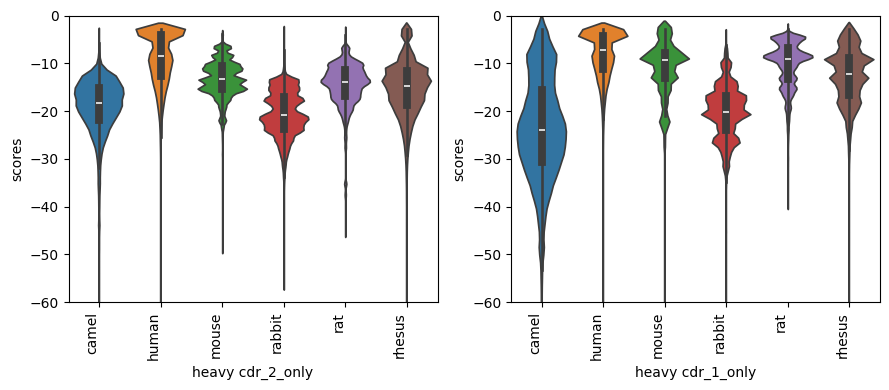

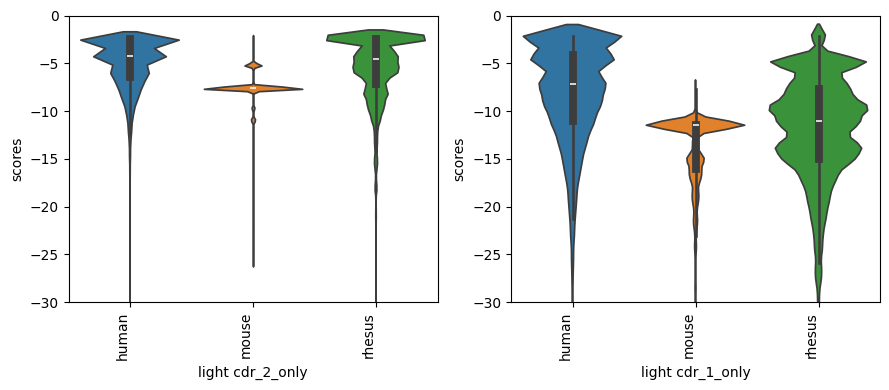

In [37]:
for chain in ["heavy", "light"]:
    fig, ((ax1,ax2)) = plt.subplots(1,2, figsize=(9,4), sharex=True)
    axes = [ax1, ax2]
    df = dfs[chain]
    
    for mask, ax in zip(df.mask_codes.unique().tolist(), axes):
        subset = df[df["mask_codes"] == mask]
        sns.violinplot(y=subset["scores"], x=subset["species"],
                    hue=subset["species"], ax=ax)
    
    
        for label in ax.get_xticklabels():
            label.set_rotation(90)
            label.set_ha('right')
        if chain == "heavy":
            ax.set_ylim(-60,0)
        else:
            ax.set_ylim(-30,0)
        ax.set_xlabel(f"{chain} {mask.replace('masked', 'only')}")

    #plt.suptitle(f"Human-likeness scores for different models\non OAS test set {chain} chains, indicated CDR regions only", y=1.05)
    plt.tight_layout()
    plt.show()